## Business Problem  

Financial institutions handle millions of transactions every day, and a small fraction of these transactions are fraudulent, leading to significant financial losses. Manual fraud detection is not scalable due to the massive volume of data.

The objective of this project is to build a machine learning model that can proactively identify fraudulent transactions in real-time and help businesses take preventive actions.


###Import Required Libraries  
In this step, we import all the necessary Python libraries required for data manipulation, visualization, and machine learning.


In [3]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier



###Load and Preview the Dataset  
Here, we load the financial transaction dataset into a pandas DataFrame for further analysis and processing. This step displays the first few rows of the dataset to understand its structure and columns.


In [5]:
df = pd.read_csv("/content/Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


###Dataset Information  
This step shows the data types of all columns and checks whether there are any missing values.
###Check for Missing Values  
Here, we verify if the dataset contains any missing or null values that need to be handled.


In [6]:
df.shape
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037297 entries, 0 to 1037296
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1037297 non-null  int64  
 1   type            1037297 non-null  object 
 2   amount          1037297 non-null  float64
 3   nameOrig        1037296 non-null  object 
 4   oldbalanceOrg   1037296 non-null  float64
 5   newbalanceOrig  1037296 non-null  float64
 6   nameDest        1037296 non-null  object 
 7   oldbalanceDest  1037296 non-null  float64
 8   newbalanceDest  1037296 non-null  float64
 9   isFraud         1037296 non-null  float64
 10  isFlaggedFraud  1037296 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 87.1+ MB


,0
step,0
type,0
amount,0
nameOrig,1
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


###Fraud vs Non-Fraud Distribution  
This visualization shows how many transactions are fraudulent and how many are normal, highlighting class imbalance.


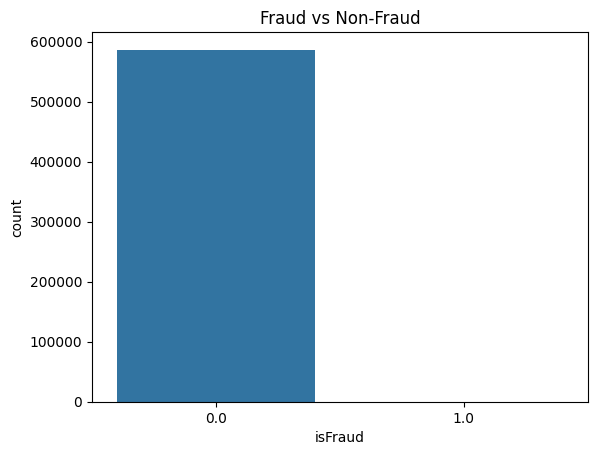

In [6]:
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()


###Transaction Type vs Fraud Analysis  
This plot analyzes how different transaction types contribute to fraudulent activities. It highlights that certain transaction types, such as TRANSFER and CASH_OUT, are more prone to fraud compared to others.


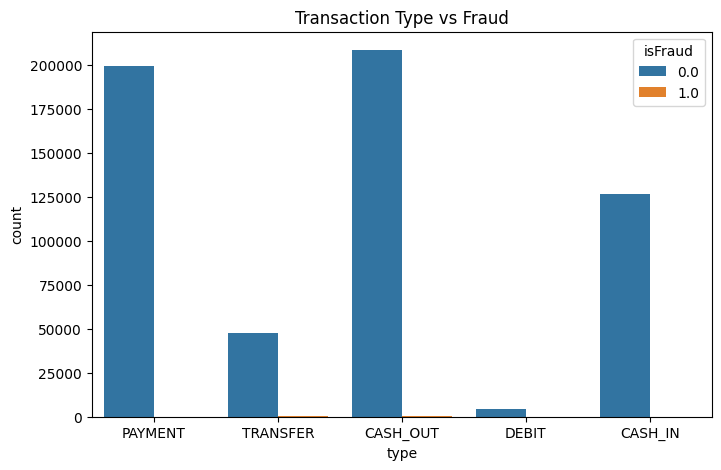

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title("Transaction Type vs Fraud")
plt.show()


### Transaction Amount vs Fraud Analysis  
This visualization analyzes how transaction amounts differ between fraud and normal cases. It shows that fraudulent transactions usually involve larger amounts, which makes amount a strong indicator for fraud detection.


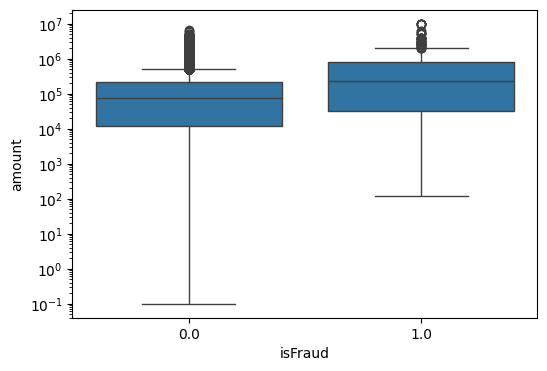

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')
plt.show()


## Feature Engineering  

New features were created to capture abnormal changes in account balances. These features represent sudden drops or increases in balances, which are strong indicators of fraudulent behavior.


In [9]:
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


## Feature Selection  

Irrelevant identifier columns such as customer IDs were removed since they do not provide predictive value. Categorical variables were encoded into numerical format.  

Final features were selected based on domain knowledge and feature importance from the trained model.


###Remove Irrelevant Columns  
Customer identifiers and system flags are removed as they do not contribute to fraud prediction.


In [10]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1, inplace=True)


###Encode Categorical Variables  
The categorical transaction type is converted into numerical form so that the machine learning model can process it.


In [11]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)


###Split the Data  
The dataset is divided into training and testing sets to evaluate model performance on unseen data.


In [12]:
df.dropna(subset=['isFraud'], inplace=True)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

###Feature Scaling  
This step standardizes numerical values so that all features are on the same scale for better model learning.


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Fraud Detection Model  

XGBoost Classifier was used for this task. XGBoost is a gradient boosting algorithm that builds multiple decision trees and learns complex non-linear patterns. It is highly effective for large and imbalanced datasets such as fraud detection problems.


###Train the Model  
The XGBoost model is trained using historical transaction data to learn fraud patterns.


In [15]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

###Make Predictions  
The trained model predicts whether each transaction in the test set is fraudulent or not.


In [20]:
y_pred = model.predict(X_test)


## Model Performance  

The model is evaluated using multiple performance metrics including accuracy, precision, recall, F1-score, confusion matrix, and ROC-AUC curve.

Accuracy alone is not sufficient due to class imbalance, therefore recall and ROC-AUC are considered more important metrics for evaluating fraud detection systems.


###Model Evaluation  
This step evaluates the model using precision, recall, F1-score, and accuracy to measure performance. ROC-AUC measures how well the model can distinguish between fraudulent and normal transactions. Although the overall accuracy is very high, recall for fraud is relatively lower due to class imbalance. In real-world fraud systems, recall is more important than accuracy because missing a fraud leads to direct financial loss.



## Threshold Optimization  

To reduce missed fraud cases, the decision threshold can be lowered from 0.5 to 0.3, which increases recall at the cost of slightly more false positives.


In [21]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc*100)


Accuracy: 99.97955637330062


The model achieved very high accuracy and strong ROC-AUC score, indicating excellent ability to distinguish between fraudulent and non-fraudulent transactions.


In [22]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    175987
         1.0       0.97      0.68      0.80       107

    accuracy                           1.00    176094
   macro avg       0.99      0.84      0.90    176094
weighted avg       1.00      1.00      1.00    176094

ROC-AUC: 0.9930736440866039


## Final Conclusion  

This project demonstrates how machine learning can be used for proactive fraud detection in financial systems. The model achieved strong predictive performance and provided actionable business insights.  

With further tuning and real-time deployment, this system can significantly reduce financial losses and improve transaction security for customers.


## Key Fraud Indicators  

The most important factors contributing to fraud prediction include high transaction amount, transaction type (TRANSFER and CASH_OUT), and sudden changes in account balances.

These factors make logical sense because fraudsters typically attempt to transfer or withdraw large amounts and empty accounts quickly.


## Fraud Prevention Strategies  

Based on model insights, the following prevention strategies are recommended:
- Real-time fraud monitoring systems  
- Multi-factor authentication for high-value transactions  
- Automated account freezing for suspicious activity  
- Alert systems for abnormal transaction behavior
